Vision Transformer에 익숙하지 않으신 분들은 다음 tutorial을 공부하는것을 추천드립니다.
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

간단하게 말씀드리면 영상(이미지)를 다루는데 기존의 convolution layer구조 가 아닌,  
Transfomer architecture with self-attention을 Image patches의 sequence에 적용했다고 보시면 됩니다. 

(Encoder, Decoder), (key, query, value), (multi-head, masked-head)등등의 복잡한 이름의 개념들이 있지만,  
image patches(content information) + Sequence (position information)이 두가지를 동시에 학습한다고 이해하시면 편합니다.

# Class Attention Image Transformers with LayerScale

[Going deeper with Image Transformers](https://arxiv.org/abs/2103.17239) by Touvron et al.

에서 사용된 CaiT (Class-Attention in Image Transformers)의 개념을 가볍게 코드로 가져가는 시간으로 활용해 주시면 감사하겠습니다.

# Introduction

## Depth Scaling

Neural Network model의 *정확도*와 *일반화* 성능이 depth를 깊게하면(layer를 많이 쌓으면) 높아지는것을 여러분도 아실 것 이라고 생각합니다.  
그에대한 근거들로 아래 두 논문을 들 수 있겠습니다.

1. [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) by Tan et al.
2. [Fast and Accurate Model Scaling](https://arxiv.org/abs/2103.06877) by Dollár et al.


## 하지만

Neural Network에서 사용되던 depth scaling전략을 Vision Transformers에 적용했을 때는,  
정확도가 너무 빨리 정체되는(더이상 상승하지 않는) 문제가 있어서 Neural Network에서만큼의 성능을 기대하기 어렵다고

[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Dollár et al. 해당 논문에서 주장하고 있습니다.

## 그래서
CaiT paper의 저자는, ViT (Vision Transformers) architecture에서 정확도 정체 현상을 완화하기 위해 두 가지의 modification을 제안합니다. 
### 1. LayerScale
### 2. Class-attention layer

이번 튜토리얼은 3단계로 이루어져있습니다.

##### step 1. Implementation of the individual blocks of CaiT - CaiT에서 사용되는 개별적인 block들 구현 ★★★★★
        - LayerScale, Class-Attentionlayer, Talking Head Attention, Stochastic depth layer
##### step 2. Collating(collect and combine) all the blocks to create the CaiT model - block들을 모아서 CaiT로 완성하기 ★★★☆☆
        - Feed-forward Network, LayerScaleBlockClassAttention, LayerScaleBlock
##### step 3.  pre-trained CaiT model 불러와서 이미지 예측해보고 model의 layer별로 결과 눈으로 확인하기! ★☆☆☆☆ 
        - 하지만 매우 practical!! 

## Imports

In [26]:
# !pip install --upgrade tensorflow

In [27]:
import io
import typing
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
tf.__version__ ##2.10.0 필수입니다!!!

'2.10.0'

## Step 1 :  CaiT 에서 사용되는 block들 만들기

## 1-1. The LayerScale layer

CaiT paper에서 제안된 두가지의 modification중에 하나인 **LayerScale**를 우선 구현해 보겠습니다.  
ViT models에서 depth를 증가시킬 때, Loss Optimization이 불안정하여 수렴하지 않는 문제가 있습니다.

ResNet구조에서 많이 접하셨으리라 생각합니다!

각각의 Transformer block에 residual connection을 연결지어서 information bottleneck 구조를 갖도록 했습니다.  
연결된 bottleneck 구조는 모델의 depth가 증가될 때, Loss Optimization이 수렴할 수 있도록 가이드를 제시하는 역할을 합니다.


# $$ x'_l = x_l + SA(\eta(x_l)) $$
# $$ x_{l+1} = x'_l + FFN(\eta(x'_l)) $$

**SA** 는 self-attention  
**FFN** 는 feed-forward network  
**$\eta$** 는 the LayerNorm operator 를 각각 의미합니다. 

요약하자면 다음식과 같이 적을 수 있습니다.
## $$x_{l+1} = x_l + SA(\eta(x_l))+ FFN(\eta(x_l + SA(\eta(x_l))))$$ 

Fixup, ReZero and SkipInit 논문에서 이전보다 낫다고 주장된 구조는 다음과 같습니다, warmup과 layer normalize를 제거함
# $$ x'_l = x_l + \alpha_l SA(x_l) $$
# $$ x_{l+1} = x'_l + \alpha'_l FFN(x'_l) $$

하지만 이또한 수렴성의 논란이 있기 때문에 새로운 구조를 소개합니다.

LayerScale의 개념은 아래의 식과같이 적을 수 있습니다. 

기존의 Residual Vit와 다른점은 diag matrix 포함돼있다는 것 입니다!

무슨 의미 인지가 제일 중요하겠죠? - per-channel multiplication of the vector produced by each residual block , as opposed to a single scalar, Our objective is to group the updates of the weights associated with the same output channel.  Formally, LayerScale is a multiplication by a diagonal matrix on output of each residual block.

# $$ x'_l = x_l + diag(\lambda_{l,1},...,\lambda_{l,d}) \times SA(\eta(x_l)) $$
# $$ x_{l+1} = x'_l + diag(\lambda'_{l,1},...,\lambda'_{l,d}) \times FFN(\eta(x'_l)) $$


**diag**는 diagonal matrix 즉, 대각 행렬을 의미합니다.  

정리를 다시 하면 다음과 같은 식이 됩니다.
#### $$ x_{l+1} = x_l + diag(\lambda_{l,1},...,\lambda_{l,d}) \times SA(\eta(x_l)) + diag(\lambda'_{l,1},...,\lambda'_{l,d}) \times FFN(\eta(x_l + diag(\lambda_{l,1},...,\lambda_{l,d}) \times SA(\eta(x_l)))) $$


수식을 통해 알수 있듯, LayerScale는 residual branches들을 control할 수 있도록 합니다.  
LayerScale의 learnable parameters은 매우 작은 숫자로 초기화하여 branches들이 identity functions의 역할을 할 수 있도록 합니다.

$\lambda$는 learnable parameters이고 매우 작은 숫자로 초기화 하여 학습합니다.  
    (depth 18까지는 0.1, depth 24까지는 0.00001, 그 이상의 depth에 대해서는 0.000001) 

이 개념은 ActNorm이나 LayerNorm과 유사하지만 residual block의 output에 적용된다는 점이 다릅니다.   
그로인한 차이점은 data-dependent한 초기화되기때문에 Batch Norm과 같은 역할이 수행되지만,   
학습 과정 내에서 identity function과 비슷하게 만들어 주고network가 additional parameters를 통합하도록 합니다.

<!-- then let them figure out the degrees of interactions during the training.  -->
The diagonal matrix additionally helps control the contributionsof the individual dimensions of the residual inputs as it is applied on a per-channel
basis.

In [29]:
#설명은 주저리주저리 많았지만 코드는 아주 간단합니다!
class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239. - Going deeper with Image Transformers

    Args:
        init_values (float): LayerScale의 diagonal matrix 초기값.
        projection_dim (int): LayerScale에서 사용되는 projection dimension.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        #tf.ones((projection_dim,)) -> [projection_dim,1] shape의 1로 이루어진 vector [1,1,...,1]
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

## 1-2. Class attention

The vanilla ViT는 image patches와 _learnable_ CLS(classification) token이 서로 어떻게 상호작용하는지 모델링(학습) 하기 위해 self-attention (SA) layers를 사용합니다. 

#### SA : image pathces와 learnable CLS token의 상호작용 학습하는 연산


CaiT의 저자는 the attention layer가 image patches와 CLS tokens들의 간의 연관성(?)을 떨어지도록 제안했습니다.  
propose to decouple the attention layers responsible for attending to the image patches and the CLS tokens.

기존에 우리가 ViTs를 classification과 같은 task에 사용할때, 보통 CLS token에 representations들이 포함되도록 한뒤 task-specific heads로 넘겨주는 방식을 사용합니다.

CNN에서 통상적으로 활용되는 global average pooling을 사용하는것에 배치됩니다.

CLS token과 다른 image patches들 간의 상호작용은 일관적이게 self-attention layer를 통해 얻어집니다.  
CaiT의 저자가 말했듯 이러한 형태는 꼬임효과(entangled effect)를 불러일으킵니다.


일례로, the self-attention layers는 the image patches를 학습하는 부분입니다.

반대로, the self-attention layers들은 또한, CLS token을 통해 얻어진 정보들을 요약하는 역할도 하기 때문에 객체를 학습하는데 유용합니다.

이 두가지의 꼬임 현상을 풀기 위해 저자는 다음과 같이 제안했습니다.

* Introduce the CLS token at a later stage in the network.
    - network의 뒷부분에 CLS token을 집어넣음
* Model the interaction between the CLS token and the representations related to the
    - CLS token과 the representations들의 상호작용이 연관되도록 modeling함

구분된 attention layer들을 통해 전해지는 image patch들 이것을 저자는 **Class Attention** (CA)라고 명명하였습니다.  
아래의 그림이 저자의 idea를 설명하고 있습니다. (논문에서 가져온 사진입니다)



<div align="center">
    <img src="https://i.imgur.com/cxeooHr.png"/ width=350>
</div>

이는 CLS token을 CA layer에서 query처럼 다루었기 때문에 얻어지는 효과입니다.  
CLS token과 image patch는 key로서 다음 layer에 전해집니다.

In [30]:
class ClassAttention(layers.Layer):
    """Class attention as proposed in CaiT: https://arxiv.org/abs/2103.17239. - Going deeper with Image Transformers

    Args:
        projection_dim (int): attention에서 사용되는 query, key, value의 projection dimension 
        num_heads      (int): attention heads의 갯수.
        dropout_rate (float): attention scores와 final projected outputs에서 사용될 dropout rate.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads

        head_dim = projection_dim // num_heads
        self.scale = head_dim**-0.5

        self.q = layers.Dense(projection_dim)
        self.k = layers.Dense(projection_dim)
        self.v = layers.Dense(projection_dim)
        self.attn_drop = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(projection_dim)
        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        batch_size, num_patches, num_channels = (
            tf.shape(x)[0],
            tf.shape(x)[1],
            tf.shape(x)[2],
        )

        # Query projection. `cls_token` embeddings이 queries로 사용됩니다.
        q = tf.expand_dims(self.q(x[:, 0]), axis=1)
        q = tf.reshape(q, (batch_size, 1, self.num_heads, num_channels // self.num_heads))  
       
        # Shape: (batch_size, 1, num_heads, dimension_per_head)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        scale = tf.cast(self.scale, dtype=q.dtype)
        q = q * scale

        # Key projection. Patch embeddings과 cls embedding이 keys로 사용됩니다.
        k = self.k(x)
        k = tf.reshape(k, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads))  
        
        # Shape: (batch_size, num_tokens, num_heads, dimension_per_head)
        k = tf.transpose(k, perm=[0, 2, 1, 3])

        # Value projection. Patch embeddings과 cls embedding이 values로 사용됩니다.
        v = self.v(x)
        v = tf.reshape(v, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads))
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        #cls_token embedding과 patch embeddings의 attention scores 계산하는 부분입니다.
        attn = tf.matmul(q, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training)

        x_cls = tf.matmul(attn, v)
        x_cls = tf.transpose(x_cls, perm=[0, 2, 1, 3])
        x_cls = tf.reshape(x_cls, (batch_size, 1, num_channels))
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls, training)

        return x_cls, attn


## 1-3. Talking Head Attention

CaiT의 저자는 기존 Transformer에서 사용되던 vanilla scaled dot-product multi-head attention 대신에
([Vaswani et al.](https://papers.nips.cc/paper/7181-attention-is-all-you-need)).  
Talking Head attention
([Shazeer et al.](https://arxiv.org/abs/2003.02436))을 사용했습니다.


추가적으로, 더 좋은 결과를 얻기 위해 sofrmax연산 전후에 linear projections을 사용하였습니다
-> 어떤 역할을 하길래?

In [31]:
class TalkingHeadAttention(layers.Layer):
    """Talking-head attention as proposed in CaiT: https://arxiv.org/abs/2003.02436. - Talking-Heads Attention

    Args:
        projection_dim (int): attention에서 사용되는 query, key, value의 projection dimension 
        num_heads      (int): attention heads의 갯수.
        dropout_rate (float): attention scores와 final projected outputs에서 사용될 dropout rate.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)

        self.num_heads = num_heads

        head_dim = projection_dim // self.num_heads

        self.scale = head_dim**-0.5

        self.qkv = layers.Dense(projection_dim * 3)
        self.attn_drop = layers.Dropout(dropout_rate)

        self.proj = layers.Dense(projection_dim)

        self.proj_l = layers.Dense(self.num_heads)
        self.proj_w = layers.Dense(self.num_heads)

        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]

        # Project the inputs all at once.
        qkv = self.qkv(x)

        # query, key, and value projections의 형태로 분리될 수 있도록 projected output을 Reshape함.
        qkv = tf.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))

        # `num_heads`가 leading dimensions이 되어 sub-spaces들의 표현이 더 잘(?) 분리될수 있도록  Transpose함.

        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])
        scale = tf.cast(self.scale, dtype=qkv.dtype)
        q, k, v = qkv[0] * scale, qkv[1], qkv[2]

        # raw attention scores 얻음.
        attn = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2]))

        # Softmax 이전에 사용되는 linear 1- query and key projections간의 유사도의 Linear projection.
        attn = self.proj_l(tf.transpose(attn, perm=[0, 2, 3, 1]))

        # Normalize the attention scores.
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = tf.nn.softmax(attn, axis=-1)

        # Softmax 이후에 사용되는 linear 2-  softmaxed scores의 Linear projection.
        attn = self.proj_w(tf.transpose(attn, perm=[0, 2, 3, 1]))
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = self.attn_drop(attn, training)

        # Vanilla attention mechanism에서 사용된것과 같은 Final set of projections.
        x = tf.matmul(attn, v)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (B, N, C))

        x = self.proj(x)
        x = self.proj_drop(x, training)

        return x, attn


## 1-4. Stochastic depth layer

Stochastic Depth([Huang et al.](https://arxiv.org/abs/1603.09382))가 소개된 이래로, 최신 모델들은 이것을 사용하는것이 트렌드 입니다.


CaiT에서도 stochastic Depth개념이 사용됐지만, 여기선 중요한 개념이 아니기때문에 가볍게 넘어가도록 하겠습니다.

간단하게만 설명하자면 전체 Neural Network layer들중에서 임의로 중간중간 layer를 skip 하여 학습 하는 개념입니다. (skip connection연산을 이용)

만약, 더 궁금하시다면 이걸[this resource](https://paperswithcode.com/method/stochastic-depth) 확인 해보면 좋을 것 같습니다.

In [32]:
class StochasticDepth(layers.Layer):
    """Stochastic Depth layer (https://arxiv.org/abs/1603.09382). - Deep Networks with Stochastic Depth

    Reference:
        https://github.com/rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob: float, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


## Other blocks

## Feed-forward Network

Transformer block에서도 사용된 feed-forward network부분 구현.

In [33]:
def mlp(x, dropout_rate: float, hidden_units: typing.List[int]):
    """FFN for a Transformer block."""
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
            bias_initializer=keras.initializers.RandomNormal(stddev=1e-6),
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# 여기가 진짜 중요 실제 모델에서 사용되는 SA와 CA를 정의

### In the next two cells, we implement the remaining blocks as standalone functions:

* SA : `LayerScaleBlock()` which returns a `keras.model`.   
다음 두개의 개념을 사용하는 Transformer block이고   
LayerScale and Stochastic Depth.  
It operates only on the embeddings of the image patches.  


* CA : `LayerScaleBlockClassAttention()` which returns a `keras.Model`.   
다음 세개의 개념을 사용하는 Transformer block이고   
Class Attention, LayerScale, and Stochastic Depth.  
It operates on the CLS embeddings and the image patch embeddings.

In [34]:
def LayerScaleBlock(
    projection_dim : int,
    num_heads      : int,
    layer_norm_eps : float,
    init_values    : float,
    mlp_units      : typing.List[int],
    dropout_rate   : float,
    sd_prob        : float,
    name           : str,
):
    """ image patches의 embeddings에 적용되는 Pre-norm transfomer block임    
    Includes LayerScale and Stochastic Depth.

        Args:
            projection_dim   (int): Transformer blocks과 patch projection layer에 사용될 projection dimension.
            num_heads        (int): attention heads의 갯수.
            layer_norm_eps (float): Layer Normalization에 사용될 epsilon.
            init_values    (float): LayerScale에서 사용되는 diagonal matrix의 초기값.
            mlp_units  (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
            dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
            sd_prob        (float): stochastic depth rate.
            name             (str): block들에 붙여줄 이름(identifier).        

    Returns:
        A keras.Model instance.
    """
    encoded_patches = keras.Input((None, projection_dim))

    # Self-attention.
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    attn_output, attn_scores = TalkingHeadAttention(projection_dim, num_heads, dropout_rate)(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = layers.Add()([encoded_patches, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, [outputs, attn_scores], name=name)

In [35]:
def LayerScaleBlockClassAttention(
    projection_dim : int,
    num_heads      : int,
    layer_norm_eps : float,
    init_values    : float,
    mlp_units      : typing.List[int],
    dropout_rate   : float,
    sd_prob        : float,
    name           : str,
):
    """ image patches과 cls token의 embeddings에 적용되는 Pre-norm transfomer block임.
    Includes LayerScale and Stochastic Depth.

    Args:   
            
        projection_dim   (int): Transformer blocks과 patch projection layer에 사용될 projection dimension.
        num_heads        (int): attention heads의 갯수.
        layer_norm_eps (float): Layer Normalization에 사용될 epsilon.
        init_values    (float): LayerScale에서 사용되는 diagonal matrix의 초기값.
        mlp_units  (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
        dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
        sd_prob        (float): stochastic depth rate.
        name             (str): block들에 붙여줄 이름(identifier).

    Returns:
        A keras.Model instance.
    """
    # x 가 SA에서 사용됐던 embedded patch와 같은 내용이고
    # 여기서 새롭게 cls가 정의되는모습!
    x = keras.Input((None, projection_dim))
    x_cls = keras.Input((None, projection_dim))
    inputs = keras.layers.Concatenate(axis=1)([x_cls, x])

    # Class attention (CA).
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(inputs)
    
    attn_output, attn_scores = ClassAttention(projection_dim, num_heads, dropout_rate)(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = keras.layers.Add()([x_cls, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = keras.layers.Add()([x2, x4])

    return keras.Model([x, x_cls], [outputs, attn_scores], name=name)

Given all these blocks, we are now ready to collate them into the final CaiT model.

## Step 2 : block들을 합쳐서 CaiT model 만들기!

In [36]:
class CaiT(keras.Model):
    """CaiT model.

    Args:
        projection_dim   (int): Transformer blocks과 patch projection layer에서 사용되는 projection dimension.
        patch_size       (int): input images의 patch size.
        num_patches      (int): image patches를 추출한 뒤의 patches갯수.
        init_values    (float): LayerScale에서 사용되는 diagonal matrix 초기값.
        mlp_units: (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
        sa_ffn_layers    (int): self-attention Transformer blocks 갯수.
        ca_ffn_layers    (int): class-attention Transformer blocks 갯수.
        num_heads        (int): attention heads 갯수.
        layer_norm_eps (float): Layer Normalization에 사용되는 epsilon.
        dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
        sd_prob        (float): stochastic depth rate.
        global_pool      (str): 마지막 Transformer block 다음에 pooling어떻게 할지 결정.
        pre_logits      (bool): True면 classification head 안넣어서 task 진행 안함 반대면 함.
        num_classes      (int): class label 갯수.
    """

    def __init__(
        self,
        projection_dim : int,
        patch_size     : int,
        num_patches    : int,
        init_values    : float,
        mlp_units      : typing.List[int],
        sa_ffn_layers  : int,
        ca_ffn_layers  : int,
        num_heads      : int,
        layer_norm_eps : float,
        dropout_rate   : float,
        sd_prob        : float,
        global_pool    : str,
        pre_logits     : bool,
        num_classes    : int,
        **kwargs,
    ):
        if global_pool not in ["token", "avg"]:
            raise ValueError(
                'Invalid value received for `global_pool`, should be either `"token"` or `"avg"`.'
            )

        super().__init__(**kwargs)

        # input images를 patchifying하고 linearly projecting하는 부분.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=projection_dim,
                    kernel_size=(patch_size, patch_size),
                    strides=(patch_size, patch_size),
                    padding="VALID",
                    name="conv_projection",
                    kernel_initializer="lecun_normal",
                ),
                layers.Reshape(
                    target_shape=(-1, projection_dim),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # CLS token 과 the positional embeddings선언.
        self.cls_token = tf.Variable(tf.zeros((1, 1, projection_dim)))
        self.pos_embed = tf.Variable(tf.zeros((1, num_patches, projection_dim)))

        # Projection dropout.
        self.pos_drop = layers.Dropout(dropout_rate, name="projection_dropout")

        # Stochastic depth schedule.
        dpr = [sd_prob for _ in range(sa_ffn_layers)]

        # image patch embeddings에 대해서만 적용되는 Self-attention (SA) Transformer blocks  
        self.blocks = [
            LayerScaleBlock(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                sd_prob=dpr[i],
                name=f"sa_ffn_block_{i}",
            )
            for i in range(sa_ffn_layers)
        ]

        # CLS token and image patch embeddings에 적용되는 Class Attention (CA) Transformer blocks.
        self.blocks_token_only = [
            LayerScaleBlockClassAttention(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                name=f"ca_ffn_block_{i}",
                sd_prob=0.0,  # No Stochastic Depth in the class attention layers.
            )
            for i in range(ca_ffn_layers)
        ]

        # Pre-classification layer normalization.
        self.norm = layers.LayerNormalization(epsilon=layer_norm_eps, name="head_norm")

        # Representation pooling for classification head.
        self.global_pool = global_pool

        # Classification head.
        self.pre_logits = pre_logits
        self.num_classes = num_classes
        if not pre_logits:
            self.head = layers.Dense(num_classes, name="classification_head")

    def call(self, x, training=False):
        # Notice how CLS token is not added here.
        x = self.projection(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # SA+FFN layers.
        sa_ffn_attn = {}
        for blk in self.blocks:
            x, attn_scores = blk(x)
            sa_ffn_attn[f"{blk.name}_att"] = attn_scores

        # CA+FFN layers 여기서 cls_tokens가 처음 involve되는것을 확인할수 있습니다.
        ca_ffn_attn = {}
        cls_tokens = tf.tile(self.cls_token, (tf.shape(x)[0], 1, 1))
        for blk in self.blocks_token_only:
            cls_tokens, attn_scores = blk([x, cls_tokens])
            ca_ffn_attn[f"{blk.name}_att"] = attn_scores

        x = tf.concat([cls_tokens, x], axis=1)
        x = self.norm(x)

        # Always return the attention scores from the SA+FFN and CA+FFN layers
        # for convenience.
        if self.global_pool:
            x = (
                tf.reduce_mean(x[:, 1:], axis=1)
                if self.global_pool == "avg"
                else x[:, 0]
            )
        return (
            (x, sa_ffn_attn, ca_ffn_attn)
            if self.pre_logits
            else (self.head(x), sa_ffn_attn, ca_ffn_attn)
        )


이런방식으로 the SA and CA layers를 나누는 것은 model의 근본적인 목적에 더 집중할 수 있도록 합니다.

* model dependencies in between the image patches
    - image patches간의 의존도를 학습하고
* summarize the information from the image patches in a CLS token that can be used for the task at hand
    - CLS token안에 있는 image patches로 부터의 정보를 요약한 정보를 더 쉽게 활용할 수 있도록 합니다.

## Defining Model Configuration

CaiT model을 custom dataset에 활용할 수 있도록 기존의 ViT에서 사용되는 config와 크게 다르지 않게 config를 설정하고,  
SA-Transformer blocks와 CA-Transformer blocks를 control하는 `sa_ffn_layers`와 `ca_ffn_layers`변수에 집중하면 편하다.

In [37]:
def get_config(
    image_size     : int = 224,
    patch_size     : int = 16,
    projection_dim : int = 192,
    sa_ffn_layers  : int = 24,
    ca_ffn_layers  : int = 2,
    num_heads      : int = 4,
    mlp_ratio      : int = 4,
    layer_norm_eps   =1e-6,
    init_values    : float = 1e-5,
    dropout_rate   : float = 0.0,
    sd_prob        : float = 0.0,
    global_pool    : str = "token",
    pre_logits     : bool = False,
    num_classes    : int = 1000,
) -> typing.Dict:
    """Default configuration for CaiT models (cait_xxs24_224).

    Reference:
        https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/cait.py
    """
    config = {}

    # Patchification and projection.
    config["patch_size"] = patch_size
    config["num_patches"] = (image_size // patch_size) ** 2

    # LayerScale.
    config["init_values"] = init_values

    # Dropout and Stochastic Depth.
    config["dropout_rate"] = dropout_rate
    config["sd_prob"] = sd_prob

    # Shared across different blocks and layers.
    config["layer_norm_eps"] = layer_norm_eps
    config["projection_dim"] = projection_dim
    config["mlp_units"] = [
        projection_dim * mlp_ratio,
        projection_dim,
    ]

    # Attention layers.
    config["num_heads"] = num_heads
    config["sa_ffn_layers"] = sa_ffn_layers
    config["ca_ffn_layers"] = ca_ffn_layers

    # Representation pooling and task specific parameters.
    config["global_pool"] = global_pool
    config["pre_logits"] = pre_logits
    config["num_classes"] = num_classes

    return config

## Model Instantiation

In [38]:
image_size = 224
num_channels = 3
batch_size = 2

config = get_config()
cait_xxs24_224 = CaiT(**config)

dummy_inputs = tf.ones((batch_size, image_size, image_size, num_channels))
_ = cait_xxs24_224(dummy_inputs)

In [39]:
print(cait_xxs24_224.summary(expand_nested=True))

Model: "cai_t_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (2, 196, 192)             147648    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_projection (Conv2D)  (2, 14, 14, 192)          147648    |
|                                                               |
| flatten_projection (Reshape  (2, 196, 192)          0         |
| )                                                             |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 projection_dropout (Dropout  multiple                 0         
 )                                                               
                                                                 
 sa_ffn_block_0 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

|                                                               |
| dense_179 (Dense)         (None, None, 192)         147648    |
|                                                               |
| dropout_119 (Dropout)     (None, None, 192)         0         |
|                                                               |
| layer_scale_59 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_59 (Add)              (None, None, 192)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sa_ffn_block_4 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_33 (InputLayer)     [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_60 (Lay  (None, None, 192)      384       |
| erNormal

| layer_scale_67 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_67 (Add)              (None, None, 192)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sa_ffn_block_8 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_37 (InputLayer)     [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_68 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| talking_head_attention_32 (  ((None, None, 192),    148264    |
| TalkingHeadAttention)      (None, 4, None, None))             |
|                                                               |
| layer_sc

 )                            (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_41 (InputLayer)     [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_76 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| talking_head_attention_36 (  ((None, None, 192),    148264    |
| TalkingHeadAttention)      (None, 4, None, None))             |
|                                                               |
| layer_scale_76 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_76 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_77 (Lay  (None, None, 192)      384       |
| erNormal

| erNormalization)                                              |
|                                                               |
| talking_head_attention_40 (  ((None, None, 192),    148264    |
| TalkingHeadAttention)      (None, 4, None, None))             |
|                                                               |
| layer_scale_84 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_84 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_85 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| dense_256 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_170 (Dropout)     (None, None, 768)         0         |
|         

| layer_scale_92 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_92 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_93 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| dense_280 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_186 (Dropout)     (None, None, 768)         0         |
|                                                               |
| dense_281 (Dense)         (None, None, 192)         147648    |
|                                                               |
| dropout_187 (Dropout)     (None, None, 192)         0         |
|                                                               |
| layer_sc

| )                                                             |
|                                                               |
| add_100 (Add)             (None, None, 192)         0         |
|                                                               |
| layer_normalization_101 (La  (None, None, 192)      384       |
| yerNormalization)                                             |
|                                                               |
| dense_304 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_202 (Dropout)     (None, None, 768)         0         |
|                                                               |
| dense_305 (Dense)         (None, None, 192)         147648    |
|                                                               |
| dropout_203 (Dropout)     (None, None, 192)         0         |
|                                                               |
| layer_sc

## Step3:  Load a pretrained model and Inference!!

In [40]:
model_gcs_path = "gs://tfhub-modules/sayakpaul/cait_xxs24_224/1/uncompressed"
pretrained_model = keras.models.load_model(model_gcs_path)

In [41]:
# The preprocessing transformations include center cropping, and normalizing
# the pixel values with the ImageNet-1k training stats (mean and standard deviation).

crop_layer = keras.layers.CenterCrop(image_size, image_size)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)

In [42]:
def preprocess_image(image, size=image_size):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / image_size) * size)
    image_resized = tf.image.resize(
        image_resized, (resize_size, resize_size), method="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    image_bytes = io.BytesIO(urlopen(url).read())
    image = PIL.Image.open(image_bytes)
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image


Now, we retrieve the ImageNet-1k labels and load them as the model we're
loading was pretrained on the ImageNet-1k dataset.

In [43]:
# ImageNet-1k class labels.
imagenet_labels = (
    "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)
label_path = keras.utils.get_file(origin=imagenet_labels,fname = 'img')

with open(label_path, "r") as f:
    lines = f.readlines()
imagenet_labels = [line.rstrip() for line in lines]

## Load an Image

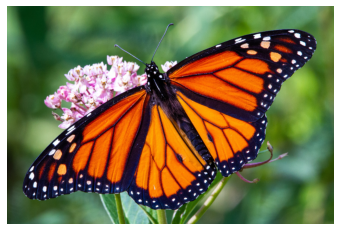

In [44]:
img_url = "https://i.imgur.com/ErgfLTn.jpg"
image, preprocessed_image = load_image_from_url(img_url)

# https://unsplash.com/photos/Ho93gVTRWW8
plt.imshow(image)
plt.axis("off")
plt.show()

## Obtain Predictions

In [45]:
a,b,c = pretrained_model.predict(preprocessed_image)
logits            = a
sa_atn_score_dict = b
ca_atn_score_dict = c

predicted_label = imagenet_labels[int(np.argmax(logits))]
print(predicted_label)

1/1 [==============================] - 3s 3s/step
monarch, monarch_butterfly, milkweed_butterfly, Danaus_plexippus


 - sa_atn_score를 통해 Self Attention Layer의 의미를
 - ca_atn_score를 통해 Class Attention Layer의 의미를 파악하도록 합니다!

## Visualizing the Attention Layers

Class Attention layer의 결과로 얻어지는 attention weights의 shape부터 확인합시다.

In [46]:
# (batch_size, nb_attention_heads, num_cls_token, seq_length)
print("class attention block에서 얻어진 attention score의 shape")
print(ca_atn_score_dict["ca_ffn_block_0_att"].shape)

class attention block에서 얻어진 attention score의 shape
(1, 4, 1, 197)


Attention weights는 얼마나 CLS token이 자기 스스로와 나머지 image patches들과 연관이 돼어있는지에대한 정보를 정량화 합니다.
Next, we write a utility to:

* Visualize what the individual attention heads in the Class Attention layers are
focusing on. This helps us to get an idea of how the _spatial-class relationship_ is
induced in the CaiT model.
* Obtain a saliency map from the first Class Attention layer that helps to understand how
CA layer aggregates information from the region(s) of interest in the images.

This utility is referred from Figures 6 and 7 of the original
[CaiT paper](https://arxiv.org/abs/2103.17239). This is also a part of
[this notebook](https://github.com/sayakpaul/cait-tf/blob/main/notebooks/classification.ipynb)
(developed by the author of this tutorial).

In [47]:
# Reference:
# https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

patch_size = 16


def get_cls_attention_map(
    attn_score_dict=ca_atn_score_dict,
    block_key="ca_ffn_block_0_att",
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attn_score_dict: dict where the attention layer names are keys and corresponding
            attention scores are values.
        block_key: name of the attention block which we want to visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    attention_scores = attn_score_dict[block_key]
    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = tf.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        method="bicubic",
    )

    return attentions


## 첫번째 CA layer의 결과 입니다

we notice that the model is focusing solely on the region of interest.

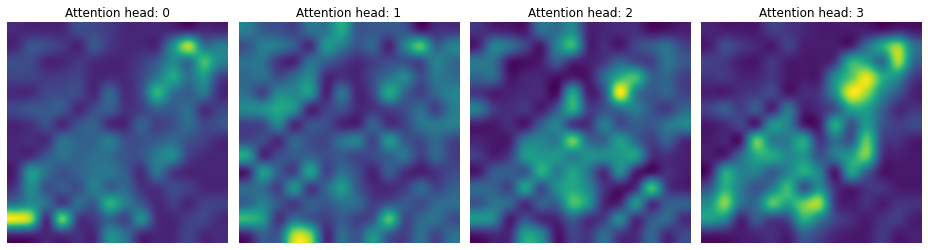

In [48]:
attentions_ca_block_0 = get_cls_attention_map()


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

## 두번째 CA layer 결과입니다.
the model is trying to focus more on the context that
contains discriminative signals.

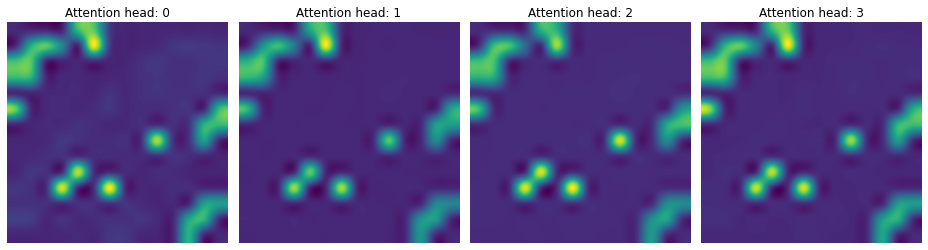

In [49]:
attentions_ca_block_1 = get_cls_attention_map(block_key="ca_ffn_block_1_att")


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_1.shape[-1]):
    if img_count < attentions_ca_block_1.shape[-1]:
        axes[i].imshow(attentions_ca_block_1[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

### 마참내!, Image의 attention map(saliency map)을 보도록 하겠습니다!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


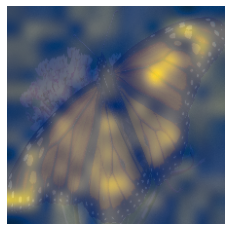

In [50]:
saliency_attention = get_cls_attention_map(return_saliency=True)

image = np.array(image)
image_resized = tf.expand_dims(image, 0)
resize_size = int((256 / 224) * image_size)
image_resized = tf.image.resize(
    image_resized, (resize_size, resize_size), method="bicubic"
)
image_resized = crop_layer(image_resized)

plt.imshow(image_resized.numpy().squeeze().astype("int32"))
plt.imshow(saliency_attention.numpy().squeeze(), cmap="cividis", alpha=0.9)
plt.axis("off")

plt.show()

## Conclusion

이 Tutorial을 통해서, 
ViTs에서의 문제였던 depth를 깊게 하는 문제를 해결하는 방법을 제시해준 CaiT model을 만들어 보았습니다. 
이걸 통해 더 많은 확장이 일어나길 바란다고 이 튜토리얼을 만든 분께서 말씀하시네요!